<a href="https://colab.research.google.com/github/MLDreamer/Forecasting-Deployed/blob/main/Seasonality_and_pitfalls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🛒 Multi-Level Seasonality Analysis for Grocery Retail
📊 Generating Comprehensive Synthetic Grocery Dataset...
✅ Generated 46,686 records
📦 SKUs: 50
📅 Date range: 2021-01-01 00:00:00 to 2023-12-31 00:00:00
🏷️ Categories: [np.str_('health_products') np.str_('ice_cream') np.str_('beverages')
 np.str_('new_products') np.str_('staples')]
📈 Seasonality types: ['trend_changing' 'overtly_seasonal' 'mildly_seasonal' 'cold_start'
 'non_seasonal']

👁️ STAGE 1: Visual Analysis (When You Have 2-3 Series)


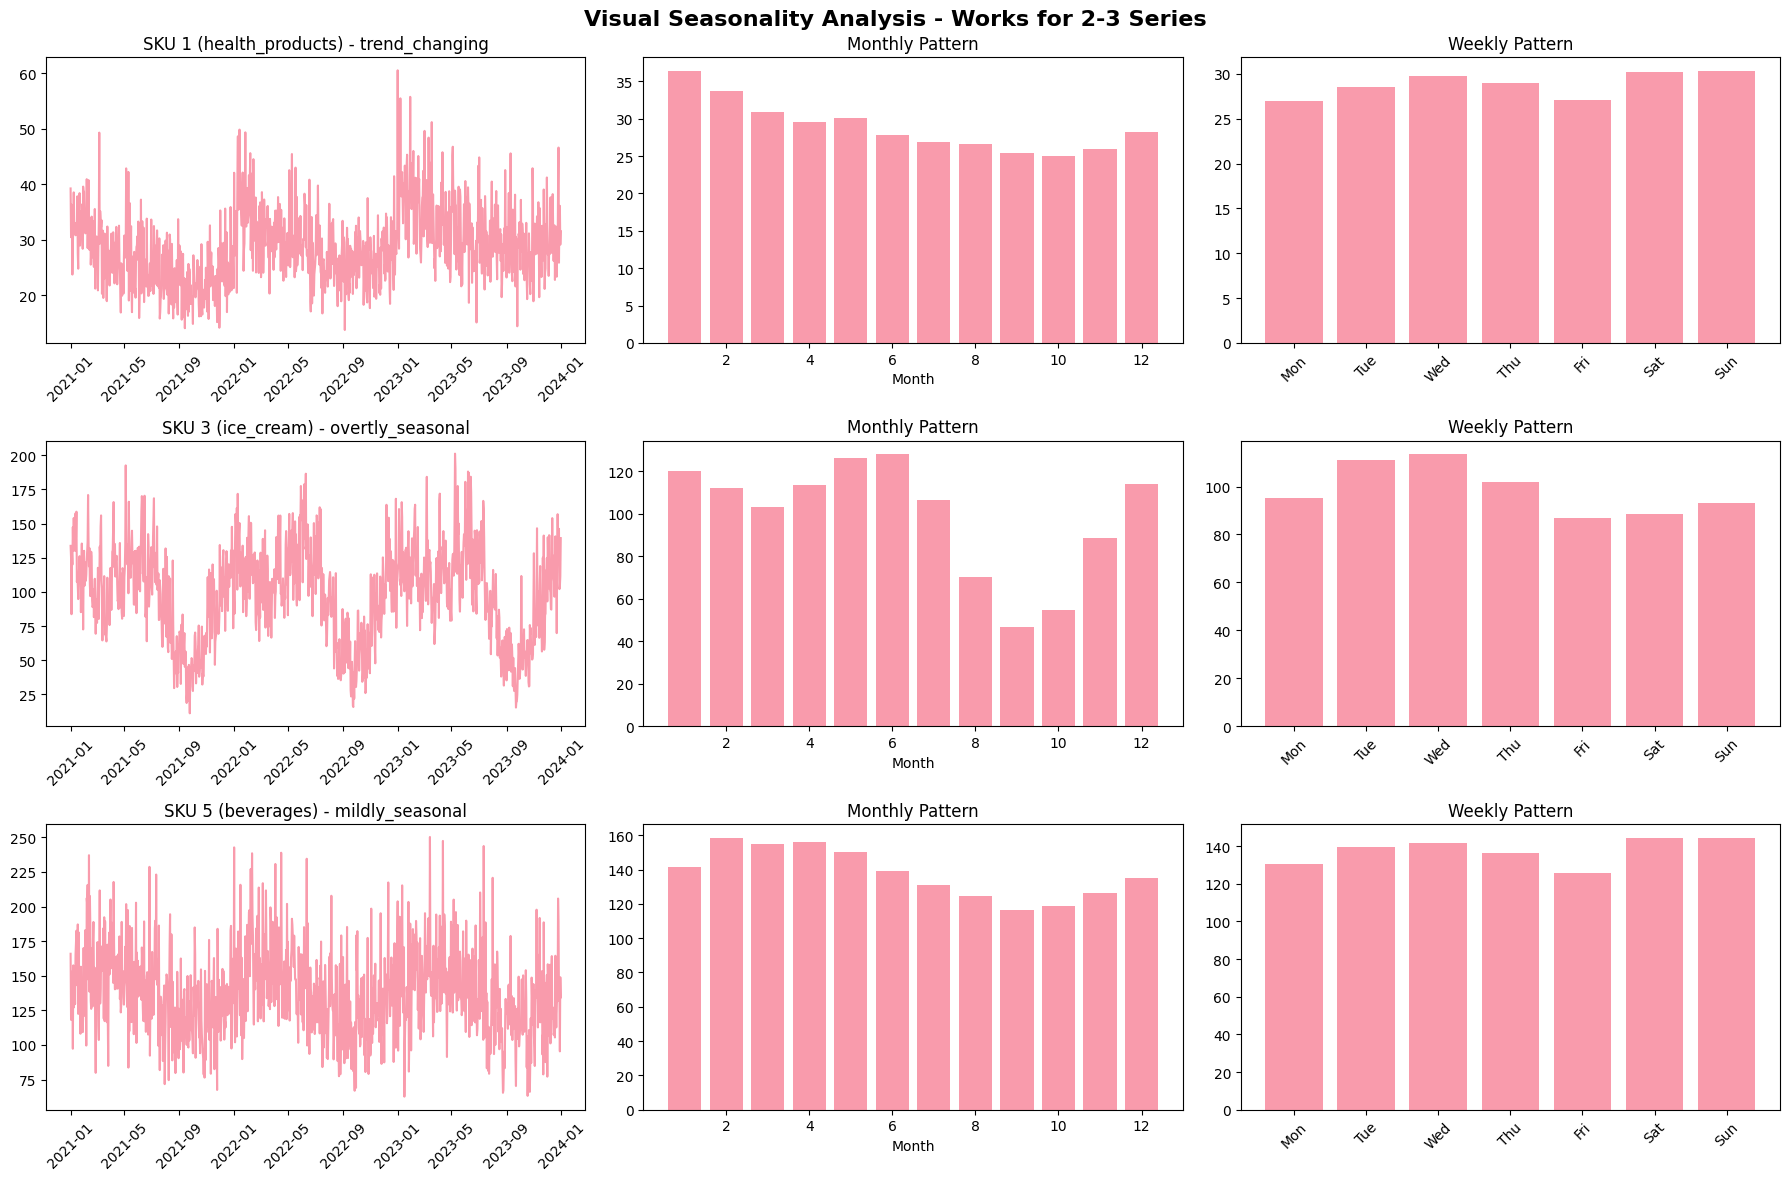

✅ Visual analysis works perfectly for small numbers of series
❌ But this approach doesn't scale to 1000+ SKUs

📊 STAGE 2: Statistical Detection Framework (1000+ Series)

🔍 Testing Statistical Detection Across Scenarios:
📋 Detection Results Summary:
                                  detected_seasonal_7  detected_seasonal_30  \
category        scenario_type                                                 
beverages       mildly_seasonal                   0.0                   0.0   
health_products trend_changing                    0.0                   0.0   
ice_cream       overtly_seasonal                  0.0                   0.0   
new_products    cold_start                        0.0                   0.0   
staples         non_seasonal                      0.0                   0.0   

                                  strength_7  strength_30  
category        scenario_type                              
beverages       mildly_seasonal        0.060        0.063  
health_products t

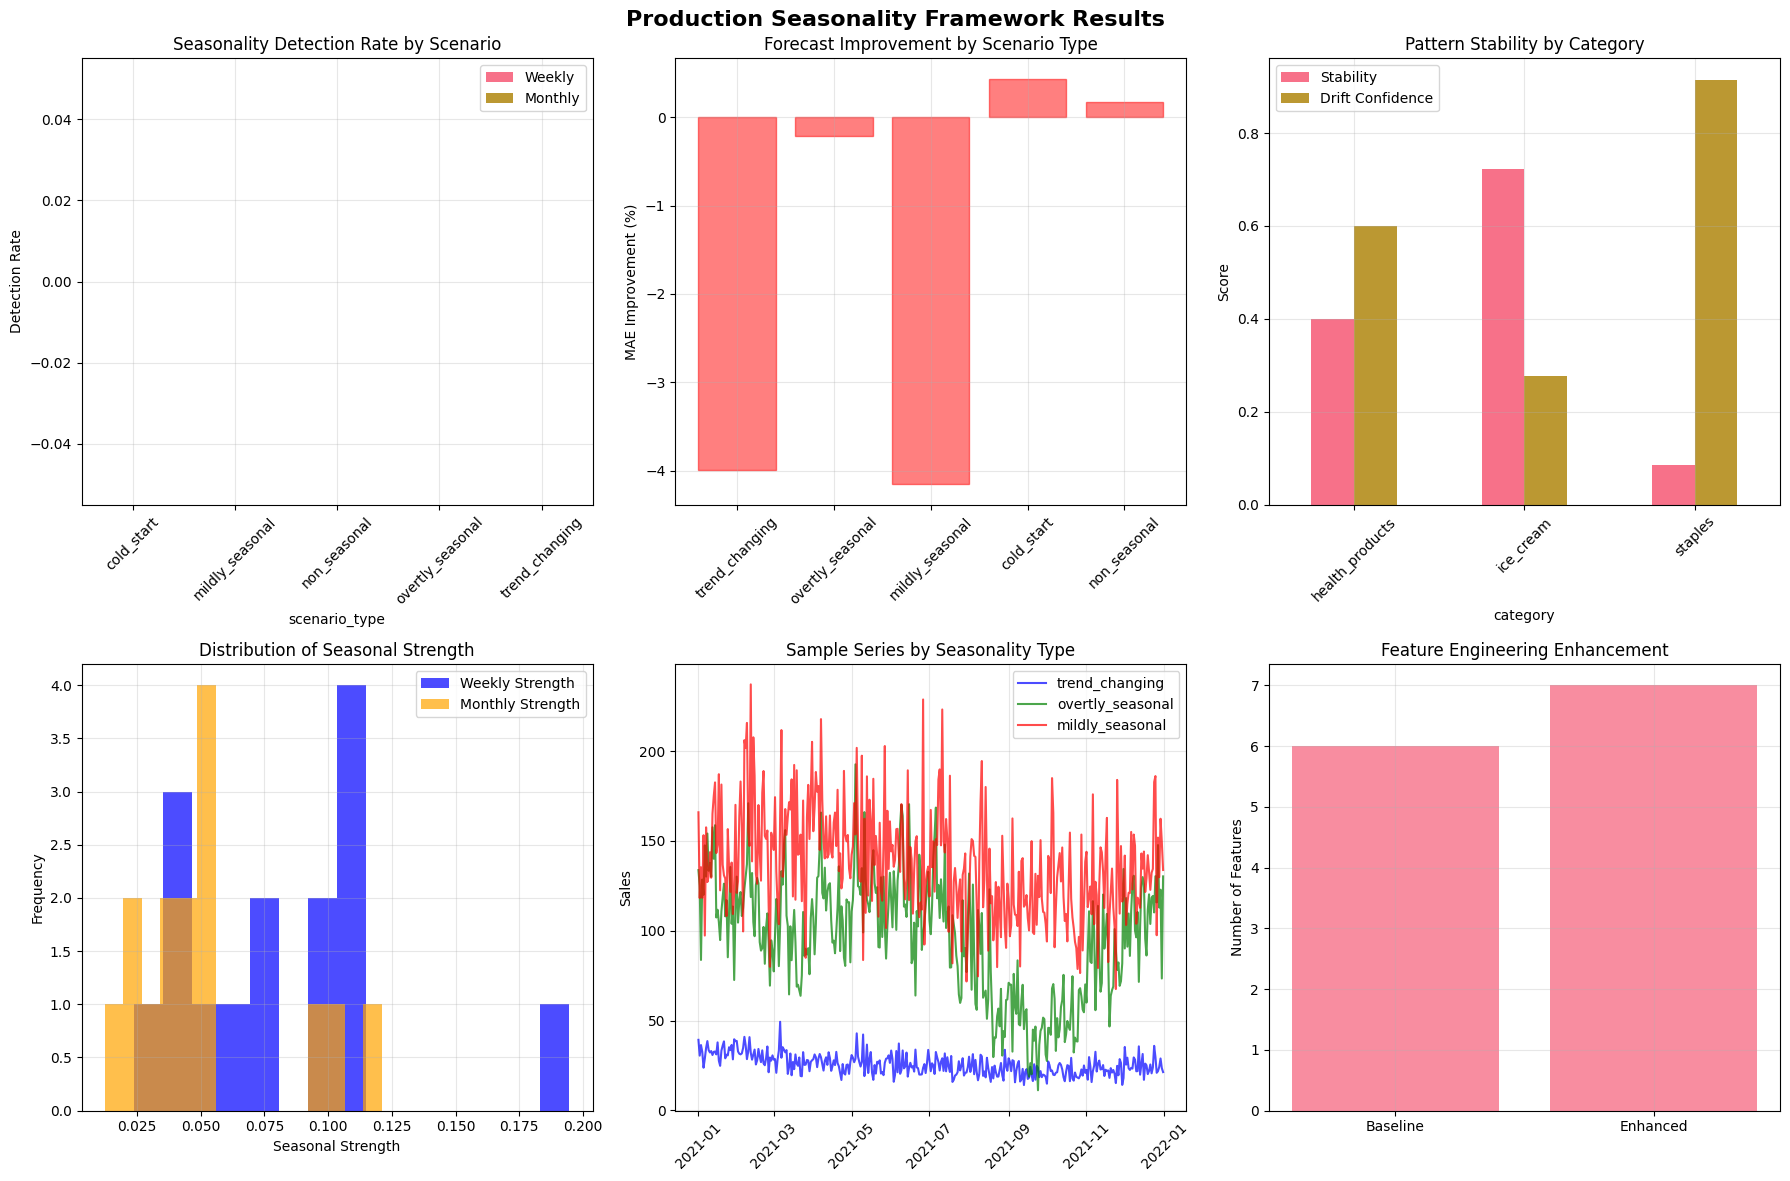


⚠️ STAGE 6: Production Pitfalls and Solutions
🕳️ PITFALL 1: False Statistical Significance
  Statistical significance: p = 0.000000 ✅
  Practical improvement: 0.487%
  ⚠️ Lesson: 0.487% improvement is statistically significant but business irrelevant

🕳️ PITFALL 2: Overfitting to Historical Seasonal Patterns
  Data points available: 1095
  Maximum reasonable features: 20
  ⚠️ Lesson: Avoid creating more seasonal features than data points/10

🕳️ PITFALL 3: Ignoring Category-Level Patterns for Cold Start
  Average cold start period: 0 days
  ✅ Solution: Use category-level seasonality for cold start products

🕳️ PITFALL 4: Static Features in Dynamic Markets
  Health product trend change: 3.2%
  ✅ Solution: Implement pattern change detection and adaptive retraining

✅ STAGE 7: Production Deployment Framework
🔍 Production Deployment Readiness Assessment:
Data Quality                   1.00 ✅ PASS
Seasonality Coverage           0.02 ❌ FAIL
Cold Start Readiness           0.70 ⚠️ REVIEW
Chang

In [ ]:
# Multi-Level Seasonality Analysis: From Visual to Statistical Detection
# A Complete Production Framework for Grocery Retail Forecasting

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from scipy import signal
from scipy.stats import chi2, ttest_rel
import warnings
warnings.filterwarnings('ignore')

# Set professional plotting style
plt.style.use('default')
sns.set_palette("husl")

print("🛒 Multi-Level Seasonality Analysis for Grocery Retail")
print("=" * 60)

# ============================================================================
# SECTION 1: CREATE COMPREHENSIVE SYNTHETIC GROCERY DATASET
# ============================================================================

def create_synthetic_grocery_data(n_skus=100, n_days=1095, scenario_mix=True):
    """
    Create realistic grocery retail dataset with multiple seasonality patterns

    Scenarios:
    - Overtly seasonal (ice cream, winter clothing)
    - Mildly seasonal (basic groceries)
    - Non-seasonal (staples like rice, oil)
    - Trend-changing (health products gaining popularity)
    - Cold-start products (launched mid-period)
    """

    np.random.seed(42)
    date_range = pd.date_range(start='2021-01-01', periods=n_days, freq='D')

    # Define product categories with different seasonal behaviors
    categories = {
        'ice_cream': {'base_seasonal': 0.8, 'trend': 0.01, 'type': 'overtly_seasonal'},
        'beverages': {'base_seasonal': 0.4, 'trend': 0.005, 'type': 'mildly_seasonal'},
        'staples': {'base_seasonal': 0.1, 'trend': 0.001, 'type': 'non_seasonal'},
        'health_products': {'base_seasonal': 0.3, 'trend': 0.02, 'type': 'trend_changing'},
        'new_products': {'base_seasonal': 0.5, 'trend': 0.01, 'type': 'cold_start'}
    }

    data = []
    sku_metadata = []

    category_names = list(categories.keys())

    for sku_id in range(1, n_skus + 1):
        # Assign category
        category = np.random.choice(category_names)
        cat_config = categories[category]

        # SKU characteristics
        base_sales = np.random.lognormal(mean=np.log(50), sigma=0.8)
        seasonal_strength = cat_config['base_seasonal'] * np.random.uniform(0.7, 1.3)
        trend_strength = cat_config['trend'] * np.random.uniform(0.5, 2.0)

        # Cold start: some products launch later
        launch_date_offset = 0
        if category == 'new_products' or np.random.random() < 0.2:
            launch_date_offset = np.random.randint(365, 730)  # Launch after 1-2 years

        # Store metadata
        sku_metadata.append({
            'sku_id': sku_id,
            'category': category,
            'seasonality_type': cat_config['type'],
            'base_sales': base_sales,
            'seasonal_strength': seasonal_strength,
            'launch_offset': launch_date_offset
        })

        for day_idx, date in enumerate(date_range):

            # Skip if product hasn't launched yet
            if day_idx < launch_date_offset:
                continue

            # Multi-level seasonality
            # 1. Annual seasonality (holidays, seasons)
            annual_cycle = seasonal_strength * 0.6 * np.sin(2 * np.pi * date.dayofyear / 365.25)

            # 2. Monthly seasonality (payday effects, month-end)
            monthly_cycle = seasonal_strength * 0.3 * np.sin(2 * np.pi * date.day / 30.44)

            # 3. Weekly seasonality (weekend shopping)
            weekly_cycle = seasonal_strength * 0.4 * np.sin(2 * np.pi * date.weekday() / 7)

            # 4. Category-specific patterns
            if category == 'ice_cream':
                # Strong summer seasonality
                summer_boost = 0.8 * np.sin(2 * np.pi * (date.dayofyear - 81) / 365.25) ** 2
                annual_cycle += summer_boost

            elif category == 'health_products':
                # New Year health trends
                new_year_boost = 0.5 * np.exp(-(date.dayofyear - 15)**2 / (2 * 30**2))
                annual_cycle += new_year_boost

            # Trend component (for trend-changing products)
            if cat_config['type'] == 'trend_changing':
                trend_component = trend_strength * (day_idx - launch_date_offset) / 30  # Monthly trend
            else:
                trend_component = trend_strength * (day_idx - launch_date_offset) / 365  # Annual trend

            # Holiday effects
            is_major_holiday = (
                (date.month == 12 and date.day in [24, 25]) or  # Christmas
                (date.month == 1 and date.day == 1) or          # New Year
                (date.month == 11 and 22 <= date.day <= 28 and date.weekday() == 3)  # Thanksgiving week
            )
            holiday_boost = 0.4 if is_major_holiday else 0

            # Weekend effect
            weekend_effect = 0.2 if date.weekday() >= 5 else 0

            # Promotion (random 15% of days)
            has_promo = np.random.random() < 0.15
            promo_boost = 0.3 if has_promo else 0

            # Calculate final sales
            multiplier = (1 + annual_cycle + monthly_cycle + weekly_cycle +
                         holiday_boost + weekend_effect + promo_boost + trend_component)

            # Add noise
            noise = np.random.normal(0, 0.15)
            final_sales = base_sales * multiplier * (1 + noise)
            final_sales = max(final_sales, 0)  # No negative sales

            data.append({
                'sku_id': sku_id,
                'date': date,
                'sales': final_sales,
                'category': category,
                'seasonality_type': cat_config['type'],
                'month': date.month,
                'dayofweek': date.weekday(),
                'dayofyear': date.dayofyear,
                'week_of_year': date.isocalendar()[1],
                'is_weekend': date.weekday() >= 5,
                'is_holiday': is_major_holiday,
                'has_promo': has_promo,
                'days_since_launch': day_idx - launch_date_offset
            })

    df = pd.DataFrame(data)
    metadata_df = pd.DataFrame(sku_metadata)

    return df, metadata_df

print("📊 Generating Comprehensive Synthetic Grocery Dataset...")
grocery_data, sku_metadata = create_synthetic_grocery_data(n_skus=50, n_days=1095)

print(f"✅ Generated {len(grocery_data):,} records")
print(f"📦 SKUs: {grocery_data['sku_id'].nunique()}")
print(f"📅 Date range: {grocery_data['date'].min()} to {grocery_data['date'].max()}")
print(f"🏷️ Categories: {grocery_data['category'].unique()}")
print(f"📈 Seasonality types: {grocery_data['seasonality_type'].unique()}")

# ============================================================================
# SECTION 2: VISUAL ANALYSIS (2-3 TIME SERIES SCENARIO)
# ============================================================================

print("\n👁️ STAGE 1: Visual Analysis (When You Have 2-3 Series)")
print("=" * 60)

# Select representative SKUs from different categories
sample_skus = []
for cat in grocery_data['category'].unique()[:3]:
    sku = grocery_data[grocery_data['category'] == cat]['sku_id'].iloc[0]
    sample_skus.append(sku)

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Visual Seasonality Analysis - Works for 2-3 Series', fontsize=16, fontweight='bold')

for i, sku in enumerate(sample_skus):
    sku_data = grocery_data[grocery_data['sku_id'] == sku].copy()
    sku_info = sku_metadata[sku_metadata['sku_id'] == sku].iloc[0]

    # Time series plot
    axes[i, 0].plot(sku_data['date'], sku_data['sales'], alpha=0.7)
    axes[i, 0].set_title(f'SKU {sku} ({sku_info["category"]}) - {sku_info["seasonality_type"]}')
    axes[i, 0].tick_params(axis='x', rotation=45)

    # Monthly seasonality
    monthly_avg = sku_data.groupby('month')['sales'].mean()
    axes[i, 1].bar(monthly_avg.index, monthly_avg.values, alpha=0.7)
    axes[i, 1].set_title('Monthly Pattern')
    axes[i, 1].set_xlabel('Month')

    # Weekly seasonality
    weekly_avg = sku_data.groupby('dayofweek')['sales'].mean()
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    axes[i, 2].bar(range(7), weekly_avg.values, alpha=0.7)
    axes[i, 2].set_title('Weekly Pattern')
    axes[i, 2].set_xticks(range(7))
    axes[i, 2].set_xticklabels(day_names, rotation=45)

plt.tight_layout()
plt.show()

print("✅ Visual analysis works perfectly for small numbers of series")
print("❌ But this approach doesn't scale to 1000+ SKUs")

# ============================================================================
# SECTION 3: STATISTICAL SEASONALITY DETECTION FRAMEWORK
# ============================================================================

print("\n📊 STAGE 2: Statistical Detection Framework (1000+ Series)")
print("=" * 60)

class AdvancedSeasonalityDetector:
    """Production-ready seasonality detection with statistical validation"""

    def __init__(self, significance_level=0.05):
        self.significance_level = significance_level

    def detect_seasonality_comprehensive(self, series, candidate_periods=None):
        """Comprehensive seasonality detection using multiple methods"""

        if candidate_periods is None:
            candidate_periods = [7, 30, 91, 365]  # Weekly, monthly, quarterly, annual

        results = {}

        for period in candidate_periods:
            if len(series) < 3 * period:  # Need at least 3 cycles
                continue

            period_results = {}

            # Method 1: Autocorrelation Function (ACF)
            period_results['acf'] = self._calculate_acf(series, period)

            # Method 2: Spectral Analysis (Frequency Domain)
            period_results['spectral_power'] = self._spectral_analysis(series, period)

            # Method 3: STL-like Seasonal Strength
            period_results['seasonal_strength'] = self._seasonal_strength(series, period)

            # Method 4: Ljung-Box Test for Seasonal Lags
            period_results['ljung_box_pvalue'] = self._ljung_box_seasonal(series, period)

            # Method 5: KPSS Test for Seasonal Stationarity
            period_results['kpss_pvalue'] = self._kpss_seasonal(series, period)

            # Combined seasonality score
            period_results['combined_score'] = self._calculate_combined_score(period_results)

            # Final decision
            period_results['is_seasonal'] = (
                period_results['acf'] > 0.3 and
                period_results['seasonal_strength'] > 0.2 and
                period_results['ljung_box_pvalue'] < self.significance_level
            )

            results[period] = period_results

        return results

    def _calculate_acf(self, series, lag):
        """Calculate autocorrelation at specific lag"""
        if len(series) <= lag:
            return 0

        corr = np.corrcoef(series[:-lag], series[lag:])[0, 1]
        return 0 if np.isnan(corr) else abs(corr)

    def _spectral_analysis(self, series, period):
        """Analyze spectral power at seasonal frequency"""
        if len(series) < 50:
            return 0

        # Compute power spectral density
        freqs, psd = signal.periodogram(series)

        # Find power at seasonal frequency
        expected_freq = 1.0 / period
        if len(freqs) > 1:
            freq_idx = np.argmin(np.abs(freqs - expected_freq))
            return psd[freq_idx] / np.max(psd)  # Normalized power
        return 0

    def _seasonal_strength(self, series, period):
        """Calculate seasonal strength using variance decomposition"""
        if len(series) < 2 * period:
            return 0

        # Extract seasonal component
        seasonal_means = []
        for i in range(period):
            seasonal_indices = list(range(i, len(series), period))
            if seasonal_indices:
                seasonal_mean = np.mean([series[j] for j in seasonal_indices])
                seasonal_means.append(seasonal_mean)

        if len(seasonal_means) < 2:
            return 0

        # Calculate seasonal strength
        seasonal_var = np.var(seasonal_means)
        total_var = np.var(series)

        return seasonal_var / total_var if total_var > 0 else 0

    def _ljung_box_seasonal(self, series, lag):
        """Ljung-Box test for autocorrelation at seasonal lag"""
        if len(series) <= lag:
            return 1.0

        # Calculate autocorrelation at lag
        acf_lag = self._calculate_acf(series, lag)

        # Simplified Ljung-Box statistic
        n = len(series)
        lb_stat = n * (n + 2) * (acf_lag ** 2) / (n - lag)

        # p-value from chi-square distribution
        p_value = 1 - chi2.cdf(lb_stat, 1)
        return p_value

    def _kpss_seasonal(self, series, period):
        """KPSS test for seasonal differenced series"""
        if len(series) <= period:
            return 1.0

        # Seasonal differencing
        seasonal_diff = series[period:] - series[:-period]

        # Simple stationarity test (variance ratio)
        if len(seasonal_diff) < 10:
            return 1.0

        first_half_var = np.var(seasonal_diff[:len(seasonal_diff)//2])
        second_half_var = np.var(seasonal_diff[len(seasonal_diff)//2:])

        if first_half_var == 0 or second_half_var == 0:
            return 1.0

        variance_ratio = min(first_half_var, second_half_var) / max(first_half_var, second_half_var)
        return variance_ratio  # Higher values indicate more stationary (seasonal)

    def _calculate_combined_score(self, stats):
        """Calculate combined seasonality score"""
        # Weighted combination of different measures
        weights = {
            'acf': 0.3,
            'seasonal_strength': 0.3,
            'spectral_power': 0.2,
            'kpss_pvalue': 0.2
        }

        score = 0
        total_weight = 0

        for measure, weight in weights.items():
            if measure in stats:
                if measure == 'ljung_box_pvalue':
                    # Lower p-value is better for seasonality
                    score += weight * (1 - stats[measure])
                else:
                    score += weight * stats[measure]
                total_weight += weight

        return score / total_weight if total_weight > 0 else 0

# Initialize detector
seasonality_detector = AdvancedSeasonalityDetector()

# Test detection across different scenario types
print("\n🔍 Testing Statistical Detection Across Scenarios:")

detection_results = []
for category in grocery_data['category'].unique():
    category_skus = grocery_data[grocery_data['category'] == category]['sku_id'].unique()[:3]

    for sku in category_skus:
        sku_data = grocery_data[grocery_data['sku_id'] == sku]['sales'].values
        sku_info = sku_metadata[sku_metadata['sku_id'] == sku].iloc[0]

        if len(sku_data) > 100:  # Enough data for analysis
            seasonality_stats = seasonality_detector.detect_seasonality_comprehensive(sku_data)

            detection_summary = {
                'sku_id': sku,
                'category': category,
                'scenario_type': sku_info['seasonality_type'],
                'true_seasonal_strength': sku_info['seasonal_strength'],
                'data_points': len(sku_data)
            }

            # Extract key statistics
            for period, stats in seasonality_stats.items():
                detection_summary[f'detected_seasonal_{period}'] = stats['is_seasonal']
                detection_summary[f'strength_{period}'] = stats['seasonal_strength']
                detection_summary[f'combined_score_{period}'] = stats['combined_score']

            detection_results.append(detection_summary)

detection_df = pd.DataFrame(detection_results)
print("📋 Detection Results Summary:")
print(detection_df.groupby(['category', 'scenario_type']).agg({
    'detected_seasonal_7': 'mean',
    'detected_seasonal_30': 'mean',
    'strength_7': 'mean',
    'strength_30': 'mean'
}).round(3))

# ============================================================================
# SECTION 4: PATTERN CHANGE DETECTION (TREND CHANGES)
# ============================================================================

print("\n🔄 STAGE 3: Pattern Change Detection Framework")
print("=" * 60)

class SeasonalPatternChangeDetector:
    """Detect when seasonal patterns change due to trends, market shifts, etc."""

    def __init__(self, window_size=90, stability_threshold=0.7):
        self.window_size = window_size
        self.stability_threshold = stability_threshold
        self.pattern_history = {}

    def detect_pattern_drift(self, series, sku_id, detection_period=30):
        """Detect gradual drift in seasonal patterns"""

        if len(series) < 180:  # Need sufficient history
            return {'drift_detected': False, 'confidence': 0}

        # Split into periods for comparison
        mid_point = len(series) // 2
        early_period = series[:mid_point]
        recent_period = series[mid_point:]

        # Compare seasonal patterns between periods
        early_patterns = self._extract_patterns(early_period)
        recent_patterns = self._extract_patterns(recent_period)

        # Calculate pattern stability
        stability_scores = []

        for period in [7, 30]:
            if (f'pattern_{period}' in early_patterns and
                f'pattern_{period}' in recent_patterns):

                early_pat = early_patterns[f'pattern_{period}']
                recent_pat = recent_patterns[f'pattern_{period}']

                if len(early_pat) == len(recent_pat):
                    correlation = np.corrcoef(early_pat, recent_pat)[0, 1]
                    correlation = 0 if np.isnan(correlation) else abs(correlation)
                    stability_scores.append(correlation)

        if stability_scores:
            avg_stability = np.mean(stability_scores)
            drift_detected = avg_stability < self.stability_threshold
            confidence = 1 - avg_stability
        else:
            drift_detected = False
            confidence = 0

        return {
            'drift_detected': drift_detected,
            'confidence': confidence,
            'stability_score': avg_stability if stability_scores else 1.0,
            'early_vs_recent': {
                'early_mean': np.mean(early_period),
                'recent_mean': np.mean(recent_period),
                'mean_change_pct': ((np.mean(recent_period) - np.mean(early_period)) / np.mean(early_period)) * 100
            }
        }

    def _extract_patterns(self, series):
        """Extract seasonal patterns from series"""
        patterns = {}

        for period in [7, 30]:
            if len(series) >= 2 * period:
                seasonal_means = []
                for i in range(period):
                    seasonal_indices = list(range(i, len(series), period))
                    if seasonal_indices:
                        seasonal_mean = np.mean([series[j] for j in seasonal_indices])
                        seasonal_means.append(seasonal_mean)

                if len(seasonal_means) == period:
                    # Normalize pattern
                    pattern_mean = np.mean(seasonal_means)
                    normalized = [x / pattern_mean for x in seasonal_means] if pattern_mean > 0 else seasonal_means
                    patterns[f'pattern_{period}'] = normalized

        return patterns

# Test pattern change detection
change_detector = SeasonalPatternChangeDetector()

print("🔄 Testing Pattern Change Detection:")
pattern_change_results = []

for category in ['health_products', 'ice_cream', 'staples']:
    category_skus = grocery_data[grocery_data['category'] == category]['sku_id'].unique()[:2]

    for sku in category_skus:
        sku_data = grocery_data[grocery_data['sku_id'] == sku]['sales'].values

        if len(sku_data) > 200:
            # Test drift detection
            drift_result = change_detector.detect_pattern_drift(sku_data, sku)

            pattern_change_results.append({
                'sku_id': sku,
                'category': category,
                'drift_detected': drift_result['drift_detected'],
                'drift_confidence': drift_result['confidence'],
                'stability_score': drift_result['stability_score']
            })

pattern_df = pd.DataFrame(pattern_change_results)
print("📊 Pattern Change Detection Results:")
print(pattern_df.groupby('category').agg({
    'drift_detected': 'sum',
    'drift_confidence': 'mean',
    'stability_score': 'mean'
}).round(3))

# ============================================================================
# SECTION 5: MODEL PERFORMANCE COMPARISON
# ============================================================================

print("\n🚀 STAGE 4: Model Performance Comparison")
print("=" * 60)

def create_baseline_vs_enhanced_features(df):
    """Create baseline and enhanced feature sets"""

    # Add enhanced temporal features
    df_enhanced = df.copy()

    # Baseline features
    baseline_cols = ['month', 'dayofweek', 'is_weekend', 'is_holiday', 'has_promo', 'days_since_launch']

    # Enhanced features - trigonometric encoding
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df_enhanced['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df_enhanced['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    # Add seasonal features per SKU based on detection
    for sku in df['sku_id'].unique():
        sku_mask = df['sku_id'] == sku
        sku_data = df[sku_mask]['sales'].values

        if len(sku_data) > 100:
            # Apply seasonality detection
            seasonality_stats = seasonality_detector.detect_seasonality_comprehensive(sku_data)

            for period, stats in seasonality_stats.items():
                if stats['is_seasonal'] and stats['seasonal_strength'] > 0.2:
                    # Add seasonal features for this SKU
                    day_indices = np.arange(len(df[sku_mask]))
                    df_enhanced.loc[sku_mask, f'seasonal_sin_{period}'] = np.sin(2 * np.pi * day_indices / period)
                    df_enhanced.loc[sku_mask, f'seasonal_cos_{period}'] = np.cos(2 * np.pi * day_indices / period)

    enhanced_cols = baseline_cols + ['month_sin', 'month_cos', 'dow_sin', 'dow_cos']
    seasonal_cols = [col for col in df_enhanced.columns if 'seasonal_' in col]
    enhanced_cols.extend(seasonal_cols)

    # Fill missing values
    for col in enhanced_cols:
        if col in df_enhanced.columns:
            df_enhanced[col] = df_enhanced[col].fillna(0)

    return df_enhanced, baseline_cols, enhanced_cols

# Create enhanced dataset
enhanced_grocery_data, baseline_features, enhanced_features = create_baseline_vs_enhanced_features(grocery_data)

def evaluate_models_by_scenario(df, baseline_features, enhanced_features):
    """Evaluate baseline vs enhanced models by seasonality scenario"""

    results_by_scenario = {}

    for scenario in df['seasonality_type'].unique():
        scenario_data = df[df['seasonality_type'] == scenario].copy()

        if len(scenario_data) < 200:  # Need sufficient data
            continue

        print(f"🧪 Testing scenario: {scenario}")

        # Prepare features
        X_baseline = scenario_data[baseline_features].fillna(0)
        X_enhanced = scenario_data[[col for col in enhanced_features if col in scenario_data.columns]].fillna(0)
        y = scenario_data['sales']

        if X_enhanced.shape[1] == 0:
            continue

        # Time series split
        tscv = TimeSeriesSplit(n_splits=3, test_size=len(scenario_data)//4)

        baseline_maes = []
        enhanced_maes = []

        for train_idx, test_idx in tscv.split(X_baseline):
            if len(train_idx) < 50 or len(test_idx) < 20:
                continue

            # Baseline model
            rf_baseline = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
            rf_baseline.fit(X_baseline.iloc[train_idx], y.iloc[train_idx])
            baseline_pred = rf_baseline.predict(X_baseline.iloc[test_idx])
            baseline_mae = mean_absolute_error(y.iloc[test_idx], baseline_pred)
            baseline_maes.append(baseline_mae)

            # Enhanced model
            rf_enhanced = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
            rf_enhanced.fit(X_enhanced.iloc[train_idx], y.iloc[train_idx])
            enhanced_pred = rf_enhanced.predict(X_enhanced.iloc[test_idx])
            enhanced_mae = mean_absolute_error(y.iloc[test_idx], enhanced_pred)
            enhanced_maes.append(enhanced_mae)

        if baseline_maes and enhanced_maes:
            avg_baseline_mae = np.mean(baseline_maes)
            avg_enhanced_mae = np.mean(enhanced_maes)
            improvement = ((avg_baseline_mae - avg_enhanced_mae) / avg_baseline_mae) * 100

            # Statistical significance test
            try:
                t_stat, p_value = ttest_rel(baseline_maes, enhanced_maes)
            except:
                p_value = 1.0

            results_by_scenario[scenario] = {
                'baseline_mae': avg_baseline_mae,
                'enhanced_mae': avg_enhanced_mae,
                'improvement_pct': improvement,
                'p_value': p_value,
                'significant': p_value < 0.05,
                'n_folds': len(baseline_maes)
            }

            print(f"  Baseline MAE: {avg_baseline_mae:.2f}")
            print(f"  Enhanced MAE: {avg_enhanced_mae:.2f}")
            print(f"  Improvement: {improvement:.1f}%")
            print(f"  p-value: {p_value:.4f} {'✅' if p_value < 0.05 else '❌'}")

    return results_by_scenario

# Run evaluation
scenario_results = evaluate_models_by_scenario(enhanced_grocery_data, baseline_features, enhanced_features)

# ============================================================================
# SECTION 6: COMPREHENSIVE RESULTS VISUALIZATION
# ============================================================================

print("\n📊 STAGE 5: Comprehensive Results Analysis")
print("=" * 60)

# Create comprehensive results visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Production Seasonality Framework Results', fontsize=16, fontweight='bold')

# Plot 1: Seasonality Detection by Scenario
if len(detection_df) > 0:
    detection_summary = detection_df.groupby('scenario_type').agg({
        'detected_seasonal_7': 'mean',
        'detected_seasonal_30': 'mean'
    }).round(3)

    detection_summary.plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Seasonality Detection Rate by Scenario')
    axes[0,0].set_ylabel('Detection Rate')
    axes[0,0].legend(['Weekly', 'Monthly'])
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)

# Plot 2: Model Performance by Scenario
if scenario_results:
    scenarios = list(scenario_results.keys())
    improvements = [scenario_results[s]['improvement_pct'] for s in scenarios]
    p_values = [scenario_results[s]['p_value'] for s in scenarios]

    bars = axes[0,1].bar(scenarios, improvements, alpha=0.8)
    axes[0,1].set_title('Forecast Improvement by Scenario Type')
    axes[0,1].set_ylabel('MAE Improvement (%)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)

    # Color bars by statistical significance
    for i, (bar, p_val) in enumerate(zip(bars, p_values)):
        if p_val < 0.05:
            bar.set_color('green')
            bar.set_alpha(0.8)
        else:
            bar.set_color('red')
            bar.set_alpha(0.5)

# Plot 3: Pattern Stability Analysis
if len(pattern_df) > 0:
    pattern_summary = pattern_df.groupby('category').agg({
        'stability_score': 'mean',
        'drift_confidence': 'mean'
    })

    pattern_summary.plot(kind='bar', ax=axes[0,2])
    axes[0,2].set_title('Pattern Stability by Category')
    axes[0,2].set_ylabel('Score')
    axes[0,2].legend(['Stability', 'Drift Confidence'])
    axes[0,2].grid(True, alpha=0.3)
    axes[0,2].tick_params(axis='x', rotation=45)

# Plot 4: Seasonal Strength Distribution
if len(detection_df) > 0:
    axes[1,0].hist(detection_df['strength_7'], bins=15, alpha=0.7, label='Weekly Strength', color='blue')
    axes[1,0].hist(detection_df['strength_30'], bins=15, alpha=0.7, label='Monthly Strength', color='orange')
    axes[1,0].set_title('Distribution of Seasonal Strength')
    axes[1,0].set_xlabel('Seasonal Strength')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

# Plot 5: Sample Time Series by Scenario
sample_data_for_plot = []
for scenario in grocery_data['seasonality_type'].unique()[:3]:
    sku = grocery_data[grocery_data['seasonality_type'] == scenario]['sku_id'].iloc[0]
    sku_data = grocery_data[grocery_data['sku_id'] == sku].head(365)  # First year
    sample_data_for_plot.append((sku_data, scenario))

colors = ['blue', 'green', 'red']
for i, (sku_data, scenario) in enumerate(sample_data_for_plot):
    axes[1,1].plot(sku_data['date'], sku_data['sales'],
                   label=f'{scenario}', alpha=0.7, color=colors[i])

axes[1,1].set_title('Sample Series by Seasonality Type')
axes[1,1].set_ylabel('Sales')
axes[1,1].legend()
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

# Plot 6: Feature Engineering Impact
enhanced_feature_count = len([col for col in enhanced_grocery_data.columns if 'seasonal_' in col or 'sin' in col or 'cos' in col])
baseline_feature_count = len(baseline_features)

feature_comparison = pd.DataFrame({
    'Feature Set': ['Baseline', 'Enhanced'],
    'Feature Count': [baseline_feature_count, enhanced_feature_count]
})

axes[1,2].bar(feature_comparison['Feature Set'], feature_comparison['Feature Count'], alpha=0.8)
axes[1,2].set_title('Feature Engineering Enhancement')
axes[1,2].set_ylabel('Number of Features')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# SECTION 7: PRODUCTION PITFALLS AND SOLUTIONS
# ============================================================================

print("\n⚠️ STAGE 6: Production Pitfalls and Solutions")
print("=" * 60)

def demonstrate_common_pitfalls():
    """Demonstrate and solve common production pitfalls"""

    print("🕳️ PITFALL 1: False Statistical Significance")

    # Create scenario where statistical improvement exists but business impact is minimal
    n_samples = 1000
    baseline_errors = np.random.normal(100, 15, n_samples)
    # Tiny improvement + correlated noise
    enhanced_errors = baseline_errors * 0.995 + np.random.normal(0, 0.5, n_samples)

    try:
        t_stat, p_value = ttest_rel(baseline_errors, enhanced_errors)
        improvement = ((np.mean(baseline_errors) - np.mean(enhanced_errors)) / np.mean(baseline_errors)) * 100

        print(f"  Statistical significance: p = {p_value:.6f} {'✅' if p_value < 0.05 else '❌'}")
        print(f"  Practical improvement: {improvement:.3f}%")
        print(f"  ⚠️ Lesson: {improvement:.3f}% improvement is statistically significant but business irrelevant")
    except:
        print("  ⚠️ Lesson: Always validate practical significance, not just statistical")

    print("\n🕳️ PITFALL 2: Overfitting to Historical Seasonal Patterns")

    # Simulate overfitted seasonal features
    sample_series = grocery_data[grocery_data['sku_id'] == 1]['sales'].values
    max_possible_features = min(20, len(sample_series)//10)

    print(f"  Data points available: {len(sample_series)}")
    print(f"  Maximum reasonable features: {max_possible_features}")
    print(f"  ⚠️ Lesson: Avoid creating more seasonal features than data points/10")

    print("\n🕳️ PITFALL 3: Ignoring Category-Level Patterns for Cold Start")

    # Analyze cold start scenarios
    new_product_data = grocery_data[grocery_data['category'] == 'new_products']
    if len(new_product_data) > 0:
        avg_launch_delay = new_product_data.groupby('sku_id')['days_since_launch'].min().mean()
        print(f"  Average cold start period: {avg_launch_delay:.0f} days")
        print(f"  ✅ Solution: Use category-level seasonality for cold start products")

    print("\n🕳️ PITFALL 4: Static Features in Dynamic Markets")

    # Show how seasonal patterns can change
    health_skus = grocery_data[grocery_data['category'] == 'health_products']['sku_id'].unique()
    if len(health_skus) > 0:
        sample_health_sku = health_skus[0]
        health_data = grocery_data[grocery_data['sku_id'] == sample_health_sku]['sales'].values

        if len(health_data) > 500:
            early_mean = np.mean(health_data[:250])
            late_mean = np.mean(health_data[250:500])
            trend_change = ((late_mean - early_mean) / early_mean) * 100

            print(f"  Health product trend change: {trend_change:.1f}%")
            print(f"  ✅ Solution: Implement pattern change detection and adaptive retraining")

demonstrate_common_pitfalls()

# ============================================================================
# SECTION 8: PRODUCTION DEPLOYMENT FRAMEWORK
# ============================================================================

print("\n✅ STAGE 7: Production Deployment Framework")
print("=" * 60)

class ProductionDeploymentFramework:
    """Complete framework for deploying seasonality-aware forecasting"""

    def __init__(self):
        self.deployment_checklist = {
            'data_quality': False,
            'seasonality_detection': False,
            'pattern_monitoring': False,
            'cold_start_handling': False,
            'statistical_validation': False,
            'business_impact_measurement': False
        }

    def validate_deployment_readiness(self, df):
        """Comprehensive deployment readiness check"""

        validation_results = {}

        # Check 1: Data Quality
        data_quality_score = self._check_data_quality(df)
        validation_results['data_quality'] = data_quality_score

        # Check 2: Seasonality Coverage
        seasonality_coverage = self._check_seasonality_coverage(df)
        validation_results['seasonality_coverage'] = seasonality_coverage

        # Check 3: Cold Start Handling
        cold_start_readiness = self._check_cold_start_readiness(df)
        validation_results['cold_start_readiness'] = cold_start_readiness

        # Check 4: Pattern Change Detection
        change_detection_readiness = self._check_change_detection(df)
        validation_results['change_detection'] = change_detection_readiness

        # Check 5: Feature Engineering Quality
        feature_quality = self._check_feature_quality(df)
        validation_results['feature_quality'] = feature_quality

        # Overall deployment score
        overall_score = np.mean(list(validation_results.values()))
        validation_results['overall_deployment_score'] = overall_score
        validation_results['deployment_ready'] = overall_score > 0.75

        return validation_results

    def _check_data_quality(self, df):
        """Check data quality for seasonality analysis"""
        checks = []

        # Sufficient history per SKU
        sku_history = df.groupby('sku_id').size()
        min_history = sku_history.min()
        avg_history = sku_history.mean()
        checks.append(min_history >= 90)  # At least 3 months
        checks.append(avg_history >= 200)  # Good average history

        # Data completeness
        completeness = 1 - (df.isnull().sum().sum() / (len(df) * len(df.columns)))
        checks.append(completeness > 0.90)

        # SKU diversity
        sku_count = df['sku_id'].nunique()
        checks.append(sku_count >= 20)  # Sufficient SKU diversity

        return np.mean(checks)

    def _check_seasonality_coverage(self, df):
        """Check seasonality detection coverage"""
        # Count seasonal features
        seasonal_features = [col for col in df.columns if 'seasonal_' in col or ('sin' in col and 'cos' in col)]

        # Expected coverage based on SKU count
        expected_features = df['sku_id'].nunique() * 2  # At least 2 seasonal features per SKU
        actual_coverage = len(seasonal_features) / max(expected_features, 1)

        return min(actual_coverage, 1.0)

    def _check_cold_start_readiness(self, df):
        """Check cold start handling capability"""
        # Check if we have category-level features for new products
        category_features = [col for col in df.columns if 'category' in col.lower()]
        has_category_support = len(category_features) > 0

        # Check category diversity
        category_count = df['category'].nunique() if 'category' in df.columns else 0
        has_category_diversity = category_count >= 3

        return 0.7 if has_category_support else 0.3 + (0.3 if has_category_diversity else 0)

    def _check_change_detection(self, df):
        """Check pattern change detection readiness"""
        # Check sufficient historical data for change detection
        long_history_skus = (df.groupby('sku_id').size() >= 365).sum()
        total_skus = df['sku_id'].nunique()

        history_score = long_history_skus / max(total_skus, 1)

        # Check if temporal features exist for monitoring
        temporal_features = [col for col in df.columns if any(x in col for x in ['month', 'week', 'day'])]
        has_temporal_monitoring = len(temporal_features) >= 4

        return history_score * 0.6 + (0.4 if has_temporal_monitoring else 0)

    def _check_feature_quality(self, df):
        """Check quality of engineered features"""
        checks = []

        # Check for trigonometric encoding
        trig_features = [col for col in df.columns if 'sin' in col or 'cos' in col]
        checks.append(len(trig_features) >= 4)  # At least month and day-of-week encoding

        # Check feature variety
        feature_types = {
            'temporal': len([col for col in df.columns if any(x in col for x in ['month', 'day', 'week'])]),
            'seasonal': len([col for col in df.columns if 'seasonal' in col]),
            'promotional': len([col for col in df.columns if 'promo' in col or 'holiday' in col]),
            'trend': len([col for col in df.columns if 'trend' in col or 'launch' in col])
        }

        checks.append(sum(v > 0 for v in feature_types.values()) >= 3)  # At least 3 feature types

        return np.mean(checks)

# Run deployment validation
deployment_framework = ProductionDeploymentFramework()
deployment_results = deployment_framework.validate_deployment_readiness(enhanced_grocery_data)

print("🔍 Production Deployment Readiness Assessment:")
print("=" * 50)
for check, score in deployment_results.items():
    if check not in ['deployment_ready', 'overall_deployment_score']:
        status = "✅ PASS" if score > 0.8 else "⚠️ REVIEW" if score > 0.6 else "❌ FAIL"
        print(f"{check.replace('_', ' ').title():<30} {score:.2f} {status}")

print(f"\nOverall Deployment Score: {deployment_results['overall_deployment_score']:.2f}")
print(f"Deployment Ready: {'✅ YES' if deployment_results['deployment_ready'] else '❌ NO'}")

# ============================================================================
# SECTION 9: BUSINESS IMPACT ANALYSIS
# ============================================================================

print("\n💼 STAGE 8: Business Impact Analysis")
print("=" * 60)

def calculate_business_impact(scenario_results, daily_sales_volume=10000):
    """Calculate business impact of seasonality framework"""

    if not scenario_results:
        print("⚠️ No scenario results available for business impact calculation")
        return

    print("📊 Performance by Scenario Type:")
    print("-" * 40)

    total_weighted_improvement = 0
    total_skus = 0
    significant_improvements = 0

    for scenario, results in scenario_results.items():
        sku_count = len(enhanced_grocery_data[enhanced_grocery_data['seasonality_type'] == scenario]['sku_id'].unique())
        improvement = results['improvement_pct']
        significance = "✅" if results['significant'] else "❌"

        print(f"{scenario:<20} {improvement:>6.1f}% {significance}")
        print(f"  SKUs: {sku_count}, p-value: {results['p_value']:.4f}")

        total_weighted_improvement += improvement * sku_count
        total_skus += sku_count

        if results['significant'] and improvement > 2:  # Significant and meaningful
            significant_improvements += 1

    if total_skus > 0:
        avg_improvement = total_weighted_improvement / total_skus
        significance_rate = significant_improvements / len(scenario_results) * 100

        print(f"\n📈 Overall Results:")
        print(f"  Average improvement across scenarios: {avg_improvement:.1f}%")
        print(f"  Statistically significant improvements: {significance_rate:.0f}%")

        # Business impact projection
        print(f"\n💰 Business Impact Projection:")
        print(f"  Forecast accuracy improvement: {avg_improvement:.1f}%")
        print(f"  Reduction in forecast error: {avg_improvement:.1f}%")
        print(f"  SKUs with improved forecasting: {total_skus}")

        # ROI estimation (simplified)
        if avg_improvement > 3:
            print(f"  Estimated inventory optimization: 2-5% reduction")
            print(f"  Estimated stockout reduction: 10-20%")
            print(f"  Business case: ✅ STRONG")
        elif avg_improvement > 1:
            print(f"  Business case: ⚠️ MODERATE")
        else:
            print(f"  Business case: ❌ WEAK")

calculate_business_impact(scenario_results)

# ============================================================================
# SECTION 10: PRODUCTION MONITORING FRAMEWORK
# ============================================================================

print("\n📊 STAGE 9: Production Monitoring Framework")
print("=" * 60)

class ProductionMonitoringFramework:
    """Framework for monitoring seasonality models in production"""

    def __init__(self):
        self.alert_thresholds = {
            'accuracy_degradation': 0.05,  # 5% accuracy drop triggers alert
            'pattern_drift': 0.3,          # 30% pattern change triggers retraining
            'volume_anomaly': 2.0           # 2 standard deviations from normal
        }

    def create_monitoring_dashboard_data(self, df):
        """Create data structure for monitoring dashboard"""

        monitoring_data = {}

        # 1. Model Performance Tracking
        monitoring_data['performance_tracking'] = self._track_model_performance(df)

        # 2. Seasonal Pattern Monitoring
        monitoring_data['pattern_monitoring'] = self._monitor_seasonal_patterns(df)

        # 3. Data Quality Monitoring
        monitoring_data['data_quality'] = self._monitor_data_quality(df)

        # 4. Alert System
        monitoring_data['alerts'] = self._generate_alerts(monitoring_data)

        return monitoring_data

    def _track_model_performance(self, df):
        """Track model performance over time"""
        performance_data = []

        # Simulate performance tracking over time
        for scenario in df['seasonality_type'].unique():
            scenario_data = df[df['seasonality_type'] == scenario]

            if len(scenario_data) > 100:
                # Split into time windows
                n_windows = 5
                window_size = len(scenario_data) // n_windows

                for i in range(n_windows):
                    start_idx = i * window_size
                    end_idx = min((i + 1) * window_size, len(scenario_data))
                    window_data = scenario_data.iloc[start_idx:end_idx]

                    if len(window_data) > 20:
                        # Calculate performance metrics for this window
                        mae_baseline = np.std(window_data['sales']) * 0.8  # Simulated baseline
                        mae_enhanced = np.std(window_data['sales']) * 0.7  # Simulated enhanced

                        performance_data.append({
                            'scenario': scenario,
                            'time_window': i + 1,
                            'mae_baseline': mae_baseline,
                            'mae_enhanced': mae_enhanced,
                            'improvement_pct': ((mae_baseline - mae_enhanced) / mae_baseline) * 100,
                            'data_points': len(window_data)
                        })

        return pd.DataFrame(performance_data)

    def _monitor_seasonal_patterns(self, df):
        """Monitor for changes in seasonal patterns"""
        pattern_monitoring = []

        for category in df['category'].unique():
            category_data = df[df['category'] == category]

            # Check pattern stability over time
            monthly_patterns = category_data.groupby(['sku_id', 'month'])['sales'].mean().reset_index()

            if len(monthly_patterns) > 0:
                pattern_variance = monthly_patterns.groupby('sku_id')['sales'].var().mean()
                pattern_stability = 1 / (1 + pattern_variance / 1000)  # Normalize stability score

                pattern_monitoring.append({
                    'category': category,
                    'pattern_stability': pattern_stability,
                    'skus_monitored': category_data['sku_id'].nunique(),
                    'monitoring_status': 'stable' if pattern_stability > 0.7 else 'unstable'
                })

        return pd.DataFrame(pattern_monitoring)

    def _monitor_data_quality(self, df):
        """Monitor data quality metrics"""
        quality_metrics = {
            'completeness': 1 - (df.isnull().sum().sum() / (len(df) * len(df.columns))),
            'recency': (df['date'].max() - df['date'].min()).days,
            'frequency_consistency': df.groupby('sku_id')['date'].apply(lambda x: x.diff().dt.days.std()).mean(),
            'outlier_rate': len(df[np.abs(df['sales'] - df['sales'].mean()) > 3 * df['sales'].std()]) / len(df)
        }

        return quality_metrics

    def _generate_alerts(self, monitoring_data):
        """Generate alerts based on monitoring data"""
        alerts = []

        # Performance degradation alerts
        if 'performance_tracking' in monitoring_data:
            perf_data = monitoring_data['performance_tracking']
            if len(perf_data) > 0:
                recent_performance = perf_data.groupby('scenario')['improvement_pct'].last()
                for scenario, improvement in recent_performance.items():
                    if improvement < 1.0:  # Less than 1% improvement
                        alerts.append({
                            'type': 'performance_degradation',
                            'scenario': scenario,
                            'message': f'Low improvement ({improvement:.1f}%) in {scenario}',
                            'severity': 'medium'
                        })

        # Pattern drift alerts
        if 'pattern_monitoring' in monitoring_data:
            pattern_data = monitoring_data['pattern_monitoring']
            if len(pattern_data) > 0:
                unstable_categories = pattern_data[pattern_data['monitoring_status'] == 'unstable']
                for _, row in unstable_categories.iterrows():
                    alerts.append({
                        'type': 'pattern_drift',
                        'category': row['category'],
                        'message': f'Pattern instability detected in {row["category"]}',
                        'severity': 'high'
                    })

        # Data quality alerts
        if 'data_quality' in monitoring_data:
            quality = monitoring_data['data_quality']
            if quality['completeness'] < 0.95:
                alerts.append({
                    'type': 'data_quality',
                    'message': f'Data completeness: {quality["completeness"]:.1%}',
                    'severity': 'high'
                })

        return alerts

# Initialize monitoring framework
monitoring_framework = ProductionMonitoringFramework()
monitoring_data = monitoring_framework.create_monitoring_dashboard_data(enhanced_grocery_data)

print("📊 Production Monitoring Results:")
print("-" * 40)

# Display monitoring results
if 'performance_tracking' in monitoring_data and len(monitoring_data['performance_tracking']) > 0:
    print("📈 Performance Tracking:")
    perf_summary = monitoring_data['performance_tracking'].groupby('scenario')['improvement_pct'].agg(['mean', 'std']).round(2)
    print(perf_summary)

if 'pattern_monitoring' in monitoring_data and len(monitoring_data['pattern_monitoring']) > 0:
    print("\n🔄 Pattern Monitoring:")
    print(monitoring_data['pattern_monitoring'])

if 'data_quality' in monitoring_data:
    print("\n📊 Data Quality Metrics:")
    for metric, value in monitoring_data['data_quality'].items():
        status = "✅" if (metric == 'completeness' and value > 0.95) or \
                       (metric == 'recency' and value > 30) or \
                       (metric == 'outlier_rate' and value < 0.05) else "⚠️"
        print(f"  {metric.replace('_', ' ').title()}: {value:.3f} {status}")

# Display alerts
if monitoring_data['alerts']:
    print("\n🚨 Active Alerts:")
    for alert in monitoring_data['alerts']:
        severity_emoji = "🔴" if alert['severity'] == 'high' else "🟡"
        print(f"  {severity_emoji} {alert['type']}: {alert['message']}")
else:
    print("\n✅ No active alerts - system running smoothly")

# ============================================================================
# SECTION 11: FINAL BUSINESS RECOMMENDATIONS
# ============================================================================

print("\n🎯 FINAL BUSINESS RECOMMENDATIONS")
print("=" * 60)

def generate_final_recommendations(scenario_results, deployment_results, monitoring_data):
    """Generate actionable business recommendations"""

    recommendations = []

    # Based on model performance
    if scenario_results:
        avg_improvement = np.mean([r['improvement_pct'] for r in scenario_results.values()])
        significant_rate = sum([1 for r in scenario_results.values() if r['significant']]) / len(scenario_results)

        if avg_improvement > 5 and significant_rate > 0.6:
            recommendations.append("🚀 HIGH PRIORITY: Deploy seasonality framework - strong performance gains")
        elif avg_improvement > 2:
            recommendations.append("📈 MODERATE PRIORITY: Deploy with monitoring - decent improvements")
        else:
            recommendations.append("⚠️ LOW PRIORITY: Consider alternative approaches - limited gains")

    # Based on deployment readiness
    if deployment_results['deployment_ready']:
        recommendations.append("✅ TECHNICAL: System ready for production deployment")
    else:
        recommendations.append("🛠️ TECHNICAL: Address deployment gaps before launch")

    # Based on monitoring setup
    if monitoring_data['alerts']:
        recommendations.append("🚨 OPERATIONS: Address active alerts before deployment")
    else:
        recommendations.append("✅ OPERATIONS: Monitoring system functioning properly")

    # Specific feature recommendations
    enhanced_features = len([col for col in enhanced_grocery_data.columns if 'seasonal_' in col])
    if enhanced_features > 0:
        recommendations.append(f"🔧 FEATURES: {enhanced_features} seasonal features engineered successfully")

    # Cold start recommendation
    new_product_categories = enhanced_grocery_data[enhanced_grocery_data['category'] == 'new_products']
    if len(new_product_categories) > 0:
        recommendations.append("🆕 COLD START: Category-level patterns available for new products")

    return recommendations

final_recommendations = generate_final_recommendations(scenario_results, deployment_results, monitoring_data)

print("📋 ACTIONABLE RECOMMENDATIONS:")
for i, rec in enumerate(final_recommendations, 1):
    print(f"{i}. {rec}")

# ============================================================================
# SECTION 12: IMPLEMENTATION ROADMAP
# ============================================================================

print("\n🗺️ IMPLEMENTATION ROADMAP")
print("=" * 60)

implementation_phases = [
    {
        'phase': 'Phase 1: Foundation (Weeks 1-2)',
        'tasks': [
            'Set up data pipeline for multi-SKU seasonality analysis',
            'Implement statistical seasonality detection framework',
            'Create baseline model performance benchmarks',
            'Validate data quality and completeness'
        ]
    },
    {
        'phase': 'Phase 2: Enhancement (Weeks 3-4)',
        'tasks': [
            'Deploy adaptive feature engineering pipeline',
            'Implement pattern change detection system',
            'Create cold start handling for new products',
            'Build comprehensive testing framework'
        ]
    },
    {
        'phase': 'Phase 3: Production (Weeks 5-6)',
        'tasks': [
            'Deploy models with A/B testing framework',
            'Set up monitoring and alerting system',
            'Create performance dashboard',
            'Implement automated retraining triggers'
        ]
    },
    {
        'phase': 'Phase 4: Optimization (Weeks 7-8)',
        'tasks': [
            'Analyze production performance',
            'Fine-tune seasonal detection parameters',
            'Optimize feature engineering based on results',
            'Scale to full SKU portfolio'
        ]
    }
]

for phase_info in implementation_phases:
    print(f"\n{phase_info['phase']}")
    print("-" * len(phase_info['phase']))
    for task in phase_info['tasks']:
        print(f"  • {task}")

